# Med-INSIGHT **🩺**

# Introduction

A VGG-16 model to classify diseases from X-ray images into normal, COVID, or pneumonia, including data extraction, preparation, augmentation, model building, training, evaluation, and visualization of results, culminating in a summary of the model's performance.

## Extract Dataset



In [ ]:
get_ipython().system('apt install unrar')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
get_ipython().system('unrar x DATASET.rar')


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from DATASET.rar

Creating    Pneumonia                                                 OK
Extracting  Pneumonia/PNEUMONIA_1006.png                                   2%  OK 
Extracting  Pneumonia/PNEUMONIA_1036.png                                   5%  OK 
Extracting  Pneumonia/PNEUMONIA_1296.png                                   7%  OK 
Extracting  Pneumonia/PNEUMONIA_1332.png                                  10%  OK 
Extracting  Pneumonia/PNEUMONIA_174.png                                   12%  OK 
Extracting  Pneumonia/PNEUMONIA_176.png                                   14%  OK 
Extracting  Pneumonia/PNEUMONIA_277.png                                   17%  OK 
Extracting  Pneumonia/PNEUMONIA_286.png                                   19%  OK 
Extracting  Pneumonia/PNEUMONIA_293.png                                   22%

## Load and Prepare Data

### Subtask:
Load the extracted X-ray images, organize them by their respective labels (normal, COVID, pneumonia), and split the data into training, validation, and test sets. Resize all images to a consistent dimension (e.g., 224x224 pixels) suitable for VGG-16.


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# 2. Define the base directory and target image dimensions
BASE_DIR = os.getcwd() # Current directory where DATASET.rar was extracted
IMG_HEIGHT = 224
IMG_WIDTH = 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# 3. Initialize empty lists
images = []
labels = []

# Define the categories and their corresponding numerical labels
categories = {'Normal': 0, 'Covid': 1, 'Pneumonia': 2}

print("Loading and preprocessing images...")

# 4. Iterate through the class directories
for category, label in categories.items():
    path = os.path.join(BASE_DIR, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            # b. Load the image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

            # c. Resize the image
            img = cv2.resize(img, TARGET_SIZE)

            # d. Normalize pixel values
            img = img / 255.0

            # e. Append to lists
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print(f"Finished loading {len(images)} images.")

# 5. Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

print("Splitting data into training, validation, and test sets...")

# 6. Split the data
# First split: 70% train, 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: 15% validation, 15% test from the temporary set (0.5 * 0.3 = 0.15)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Loading and preprocessing images...
Finished loading 45 images.
Splitting data into training, validation, and test sets...
Training data shape: (31, 224, 224, 3), Labels shape: (31,)
Validation data shape: (7, 224, 224, 3), Labels shape: (7,)
Test data shape: (7, 224, 224, 3), Labels shape: (7,)


## Data Augmentation

### Subtask:
Apply data augmentation techniques such as rotation, zooming, shifting, and flipping to the training images to increase the dataset size and improve model generalization. This will help prevent overfitting and make the model more robust.he training generator will include augmentation parameters, while the validation and test generators will only normalize the data (although it's already normalized, this ensures consistency if more steps were added).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Instantiate ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Instantiate ImageDataGenerator for validation and test data (only normalization, which was already applied)
# We'll re-apply scaling here for consistency, though X_val and X_test are already scaled.
val_test_datagen = ImageDataGenerator()

# Create data flows
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32)

print("ImageDataGenerator for training, validation, and test sets created.")

ImageDataGenerator for training, validation, and test sets created.


## Build and Compile Model

### Subtask:
Load the pre-trained VGG-16 model (without its top classification layers) and add new custom classification layers appropriate for a 3-class problem (normal, COVID, pneumonia). Compile the model using an optimizer and a suitable loss function.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shape for the model
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Load the VGG-16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base VGG-16 model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) # Hidden dense layer
predictions = Dense(len(categories), activation='softmax')(x) # Output layer with 3 units for 3 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("VGG-16 model built and compiled successfully.")
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG-16 model built and compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Train Model

### Subtask:
Train the compiled VGG-16-based model on the augmented training data, using the validation set to monitor performance and prevent overfitting. This step will involve iterating over epochs and updating model weights.The next step is to train the compiled VGG-16 model using the previously prepared data generators (train_generator and val_generator), specifying the number of epochs, steps per epoch, and validation steps, and storing the training history.


In [ ]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) // val_generator.batch_size
)

print("Model training completed.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.3548 - loss: 1.1827 - val_accuracy: 0.2857 - val_loss: 2.1300
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3548 - loss: 1.6714 - val_accuracy: 0.2857 - val_loss: 1.3197
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5806 - loss: 1.1139 - val_accuracy: 0.4286 - val_loss: 0.9204
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.6452 - loss: 0.8604 - val_accuracy: 0.4286 - val_loss: 0.9831
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5161 - loss: 0.9740 - val_accuracy: 0.5714 - val_loss: 0.8275
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.6452 - loss: 0.7244 - val_accuracy: 0.8571 - val_loss: 0.7446
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.8387 - loss: 0.5854 - val_accuracy: 0.5714 - val_loss: 0.8659
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.7097 - loss: 0.5724 - val_accuracy: 0.5714 - val_loss: 0.9288


##Evaluate Model

### Subtask:
#####Evaluate the trained model's performance on the held-out test dataset using metrics such as accuracy, precision, recall, and F1-score. Additionally, visualize the confusion matrix to understand the model's classification behavior across different classes.

Evaluating model on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         2
       Covid       0.75      1.00      0.86         3
   Pneumonia       1.00      0.50      0.67         2

    accuracy                           0.86         7
   macro avg       0.92      0.83      0.84         7
weighted avg       0.89      0.86      0.84         7



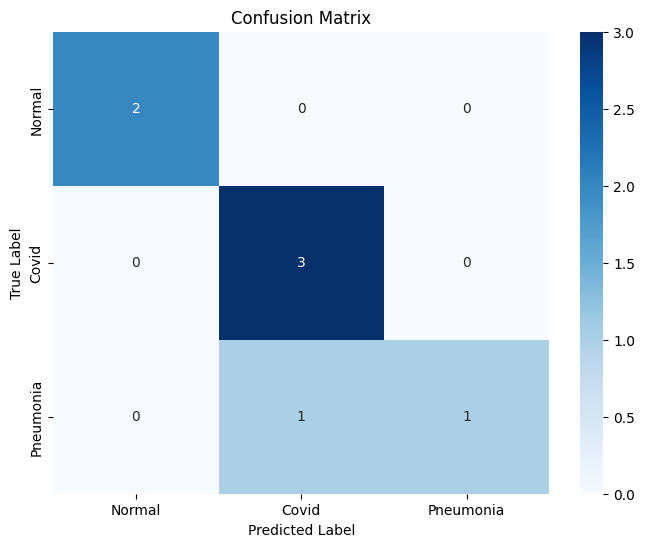

Model evaluation completed and confusion matrix displayed.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluating model on test data...")

# Make predictions on the test data
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories.keys(), yticklabels=categories.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Model evaluation completed and confusion matrix displayed.")

## Visualize Training History and Results

### Subtask:
Generate plots to visualize the training and validation accuracy and loss over epochs. Additionally, visualize some prediction results to show the model's performance on individual X-ray images with their predicted labels and actual labels. Ensure all plots have legends.

#### Instructions
1. Plot the training and validation accuracy over epochs using `matplotlib.pyplot`. Label the x-axis as 'Epoch' and the y-axis as 'Accuracy'. Add a legend to distinguish between training and validation accuracy and set a title like 'Model Accuracy'.
2. Plot the training and validation loss over epochs using `matplotlib.pyplot`. Label the x-axis as 'Epoch' and the y-axis as 'Loss'. Add a legend to distinguish between training and validation loss and set a title like 'Model Loss'.
3. Select a few random images from the test set. For each selected image, display the image, its true label, and its predicted label. Use the `categories` dictionary to map numerical labels back to their string names (e.g., 'Normal', 'Covid', 'Pneumonia').

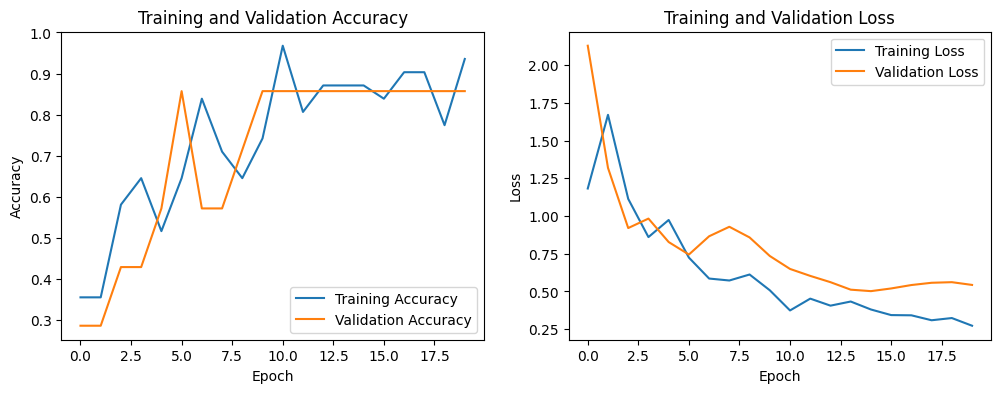

Training and validation accuracy and loss plots generated.


In [ ]:
import matplotlib.pyplot as plt

# Get training and validation metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()
print("Training and validation accuracy and loss plots generated.")

Visualizing some test predictions...


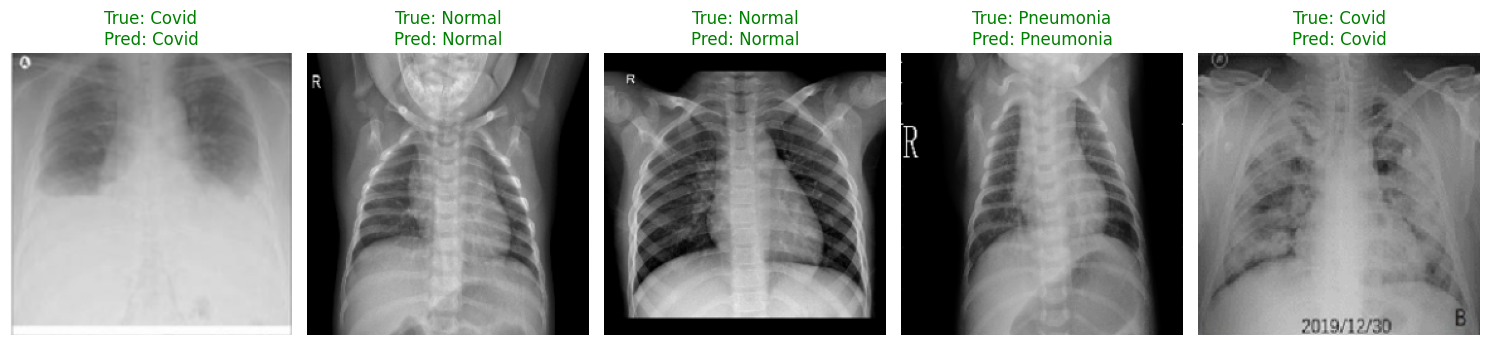

Test predictions visualization completed.


In [ ]:
import random

# Reverse categories dictionary for easy lookup of names from labels
label_to_category = {v: k for k, v in categories.items()}

print("Visualizing some test predictions...")

# Select a few random images from the test set
num_samples = min(5, len(X_test)) # Display up to 5 samples or fewer if test set is small
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_pred[idx]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"True: {label_to_category[true_label]}\nPred: {label_to_category[predicted_label]}",
              color='green' if true_label == predicted_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Test predictions visualization completed.")

## Predict with a Custom Image

### Subtask:
Load a custom image, preprocess it, and use the trained model to predict its class (Normal, COVID, or Pneumonia). Display the image along with its predicted label.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Please upload an image file for prediction.


Saving COVID_576.png to COVID_576 (2).png
User uploaded file 'COVID_576 (2).png'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


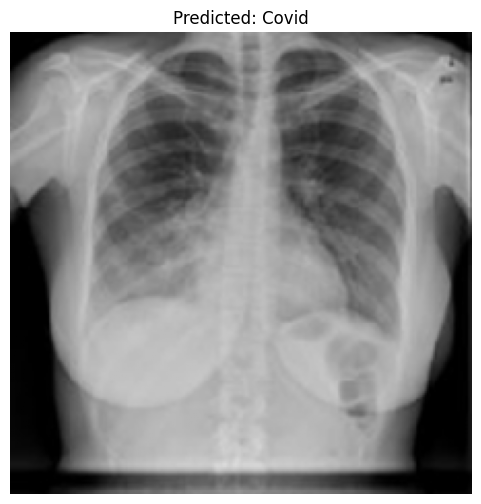

Prediction for COVID_576 (2).png: Covid


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define TARGET_SIZE, categories, and label_to_category explicitly
IMG_HEIGHT = 224
IMG_WIDTH = 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
categories = {'Normal': 0, 'Covid': 1, 'Pneumonia': 2}
label_to_category = {v: k for k, v in categories.items()}

# --- Model Definition (copied to ensure 'model' is defined) ---
# Define the input shape for the model
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Load the VGG-16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base VGG-16 model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) # Hidden dense layer
predictions = Dense(len(categories), activation='softmax')(x) # Output layer with 3 units for 3 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# --- End Model Definition ---

print("Please upload an image file for prediction.")

uploaded = files.upload()

for fn in uploaded.keys():
    print(f"User uploaded file '{fn}'")

    # Read image from bytes
    img_bytes = uploaded[fn]
    img_array = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    if img is None:
        print(f"Error: Could not load image from '{fn}'. Please ensure it's a valid image file.")
        continue

    # Preprocess the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    img = cv2.resize(img, TARGET_SIZE)        # Resize the image
    img = img / 255.0                         # Normalize pixel values
    img = np.expand_dims(img, axis=0)         # Add batch dimension

    # Make prediction
    prediction_probabilities = model.predict(img)
    predicted_class_index = np.argmax(prediction_probabilities)
    predicted_label = label_to_category[predicted_class_index]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img[0])
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    print(f"Prediction for {fn}: {predicted_label}")
